In [29]:
import pandas as pd
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import math

In [30]:
# read input file
filepath = "space_mountain.csv"
df = pd.read_csv(filepath)

In [31]:
# ------ SPLITTING DATASET ------
# train on 2014 (December), 2015, 2016, 2017, 2018, 2019, 2022 (excluding COVID years)
# test on 2023, 2024, 2025 (January - March)
train_years = ['14', '15', '16', '17', '18', '19', '22']
test_years = ['23', '24', '25']

df['Year'] = df['Date'].apply(lambda x: x.split('/')[-1])  # Extract year as a string
train_df = df[df['Year'].isin(train_years)]  # Filter rows where Year is in train_years
test_df = df[df['Year'].isin(test_years)]  # Filter rows where Year is in train_years

train_df.shape, test_df.shape

((52147, 7), (20042, 7))

In [32]:
# ------ TRAINING ------
# getting unique day and time values for training model
week_day_list = np.unique(train_df['Day of Week'])
time_list = np.unique(train_df['Time of Day'])

week_day_list, time_list

(array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
        'Wednesday'], dtype=object),
 array([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,  300,
         330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,
         660,  690,  720,  750,  780,  810,  840,  870,  900,  930,  960,
         990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290,
        1320, 1350, 1380, 1410]))

In [33]:
# getting averages across time of day per week day
avg_vals = {}
for day in week_day_list:
    for time in time_list:
        avg = (train_df[(train_df['Day of Week'] == day) & (train_df['Time of Day'] == time)]['Wait Time'].mean())
        avg_vals[(day, time)] = avg

# removing NaN values
avg_vals = {k: int(v) for k, v in avg_vals.items() if not math.isnan(v)}

avg_vals

{('Friday', 0): 39,
 ('Friday', 30): 28,
 ('Friday', 60): 21,
 ('Friday', 90): 30,
 ('Friday', 120): 10,
 ('Friday', 390): 45,
 ('Friday', 420): 25,
 ('Friday', 450): 11,
 ('Friday', 480): 10,
 ('Friday', 510): 19,
 ('Friday', 540): 23,
 ('Friday', 570): 33,
 ('Friday', 600): 41,
 ('Friday', 630): 46,
 ('Friday', 660): 52,
 ('Friday', 690): 55,
 ('Friday', 720): 57,
 ('Friday', 750): 54,
 ('Friday', 780): 54,
 ('Friday', 810): 53,
 ('Friday', 840): 55,
 ('Friday', 870): 58,
 ('Friday', 900): 58,
 ('Friday', 930): 59,
 ('Friday', 960): 58,
 ('Friday', 990): 61,
 ('Friday', 1020): 58,
 ('Friday', 1050): 63,
 ('Friday', 1080): 63,
 ('Friday', 1110): 61,
 ('Friday', 1140): 64,
 ('Friday', 1170): 62,
 ('Friday', 1200): 65,
 ('Friday', 1230): 62,
 ('Friday', 1260): 59,
 ('Friday', 1290): 56,
 ('Friday', 1320): 65,
 ('Friday', 1350): 62,
 ('Friday', 1380): 50,
 ('Friday', 1410): 49,
 ('Monday', 0): 32,
 ('Monday', 30): 37,
 ('Monday', 60): 62,
 ('Monday', 90): 30,
 ('Monday', 120): 30,
 ('Mon

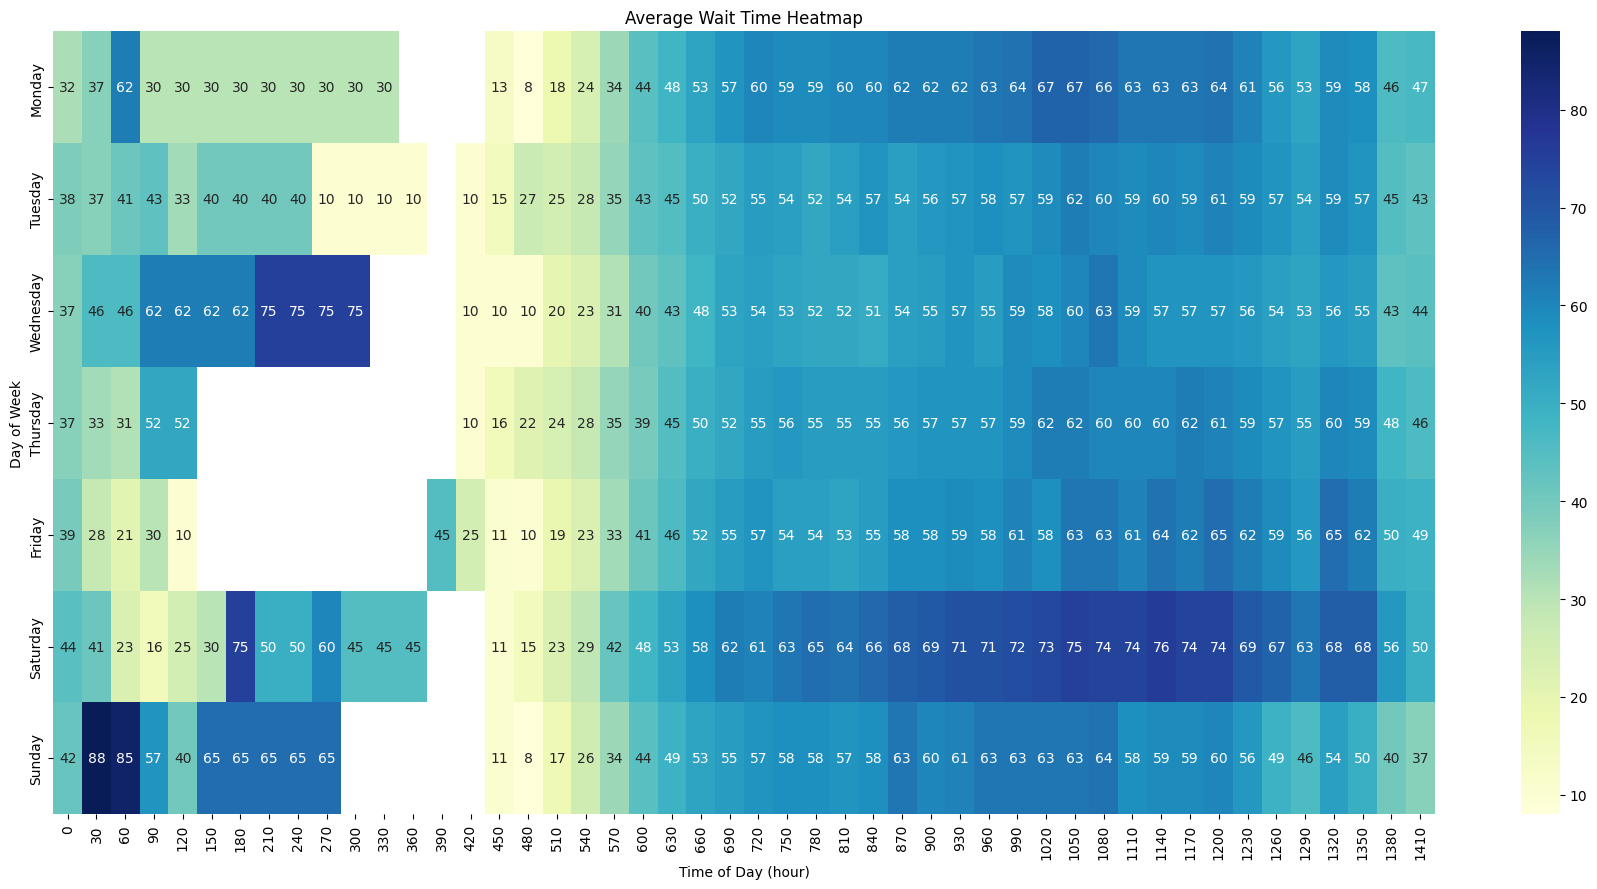

In [43]:
# Convert avg_vals dict to DataFrame
heatmap_df = pd.DataFrame([
    {"Day": day, "Time": time, "Wait": wait}
    for (day, time), wait in avg_vals.items()
])

# Pivot to get matrix format: rows = Day, columns = Time
pivot_df = heatmap_df.pivot(index="Day", columns="Time", values="Wait")

# Optional: reorder days for proper weekday sequence
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_df = pivot_df.reindex(ordered_days)

# Plot
plt.figure(figsize=(18, 9))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Average Wait Time Heatmap")
plt.xlabel("Time of Day (hour)")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

In [ ]:
# ------ TESTING ------
# getting the actual values for the test set
y_test_actual = test_df['Wait Time'].values
y_pred = []

for index, row in test_df.iterrows():
    day = row['Day of Week']
    time = row['Time of Day']
    if (day, time) in avg_vals:
        # if the day and time is in the training set, use the average value
        y_pred.append(avg_vals[(day, time)])
    else:
        y_pred.append(np.nan)

# replacing nan values with mean of the training set
y_pred = [int(x) if not math.isnan(x) else int(np.mean(list(avg_vals.values()))) for x in y_pred]

y_pred[:10]

[42, 88, 85, 8, 17, 26, 34, 44, 49, 53]

In [ ]:
# # calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("RMSE: {}".format(rmse))

RMSE: 17.449087701384784


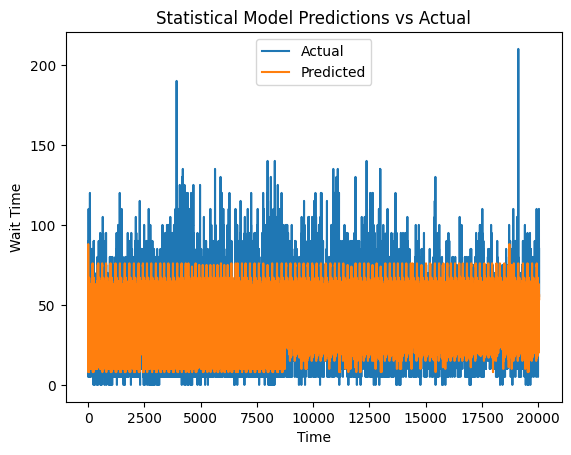

In [ ]:
# plotting results of testing statistical model
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Statistical Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Wait Time')
plt.legend()
plt.show()